# Tree-based classification of academic performance
<img src="logo.png",width=140,height=140, align="right">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy import argmax
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from visualise import compare_classes_interactively, plot_confusion_matrix

%matplotlib inline

# Display all columns of dataframes
pd.set_option('display.max_columns', None)

This tutorial considers decision trees, which are highly interpretable classification algorithms. 

After completing the notebook, you will be able to: 
* Program decision trees with [scikit-learn](http://scikit-learn.org/stable/).
* Explore and manipulate data with [pandas](http://pandas.pydata.org/).
* Visualise data with [matplotlib](https://matplotlib.org/).
* Transform categoric features from dense to one-hot encoding.
* Evaluate classifier performance using metrics such as precision, recall,...
* Determine which features in a dataset have higher predictive power. 

In addition, you will gain a better understanding of:
* Problems generated by class imbalance. 
* Model training, validation and testing. 

We will consider a dataset that summarises the academic performance of students attending courses such as History, Maths, Arabic,... Starting from this information, we will build a model to predict whether a future student will achieve a low (H), medium (M) or high (H) mark on a given subject. While the problem can be solved using different machine learning techniques, we will focus on decision trees classifiers. 

Although we have uploaded the dataset in SherlockML for you, we obtained this resource from Kaggle. Indeed, you are encouraged to look up the [corresponding website](https://www.kaggle.com/aljarah/xAPI-Edu-Data), where you can learn more about the dataset, and gain inspiration from the work of other machine-learning enthusiasts. The dataset was collected by the authors of the following papers, which are also valuable resources: 

* Amrieh, E. A., Hamtini, T., & Aljarah, I. (2016). Mining Educational Data to Predict Student’s academic Performance using Ensemble Methods. International Journal of Database Theory and Application, 9(8), 119-136.
* Amrieh, E. A., Hamtini, T., & Aljarah, I. (2015, November). Preprocessing and analyzing educational data set using X-API for improving student's performance. In Applied Electrical Engineering and Computing Technologies (AEECT), 2015 IEEE Jordan Conference on (pp. 1-5). IEEE.

**Exercise 1:**
Use `pandas` to load the file `xAPI-Edu-Data.csv` into a dataframe called `students`. 

In [2]:
# Read dataset into memory
students = pd.read_csv("xAPI-Edu-Data.csv")

# Display five rows selected at random
students.sample(5)

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
235,M,KW,KuwaIT,MiddleSchool,G-07,B,Science,S,Father,12,8,18,26,No,Bad,Above-7,L
95,F,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,100,80,2,70,No,Bad,Under-7,H
31,M,KW,KuwaIT,MiddleSchool,G-07,A,IT,F,Father,4,5,40,16,Yes,Good,Above-7,L
263,M,Egypt,Egypt,lowerlevel,G-04,A,Math,S,Mum,49,94,42,7,No,Bad,Above-7,M
369,F,Palestine,Jordan,lowerlevel,G-02,A,Arabic,S,Mum,75,81,51,34,No,Good,Under-7,H


## Data exploration

Before starting to build a classifier, it is worthwhile to spend time exploring the data. Gaining a qualitative understanding of the dataset will enable you to sense-check results obtained at a later stage. A quick analysis can establish whether a dataset is clean, or whether null values occur. Similarly, generating a few plots can identify which features are predictive, as they reveal differences among the classes.

**Exercise 2:** Inspect your dataset using the functions `.info()` and `.describe()` from `pandas`. 


In [3]:
# Basic info about columns
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
gender                      480 non-null object
NationalITy                 480 non-null object
PlaceofBirth                480 non-null object
StageID                     480 non-null object
GradeID                     480 non-null object
SectionID                   480 non-null object
Topic                       480 non-null object
Semester                    480 non-null object
Relation                    480 non-null object
raisedhands                 480 non-null int64
VisITedResources            480 non-null int64
AnnouncementsView           480 non-null int64
Discussion                  480 non-null int64
ParentAnsweringSurvey       480 non-null object
ParentschoolSatisfaction    480 non-null object
StudentAbsenceDays          480 non-null object
Class                       480 non-null object
dtypes: int64(4), object(13)
memory usage: 63.8+ KB


In [4]:
# Further info about numeric columns
students.describe()

,raisedhands,VisITedResources,AnnouncementsView,Discussion
count,480.000000,480.000000,480.000000,480.000000
mean,46.775000,54.797917,37.918750,43.283333
std,30.779223,33.080007,26.611244,27.637735
min,0.000000,0.000000,0.000000,1.000000
25%,15.750000,20.000000,14.000000,20.000000
50%,50.000000,65.000000,33.000000,39.000000
75%,75.000000,84.000000,58.000000,70.000000
max,100.000000,99.000000,98.000000,99.000000


**Exercise 3**: For students that achieved a low score (`Class = L`), plot a histogram describing how many times they raised their hands. Do the same for students that achieved medium and high scores (`Class = M` and `Class = H`).

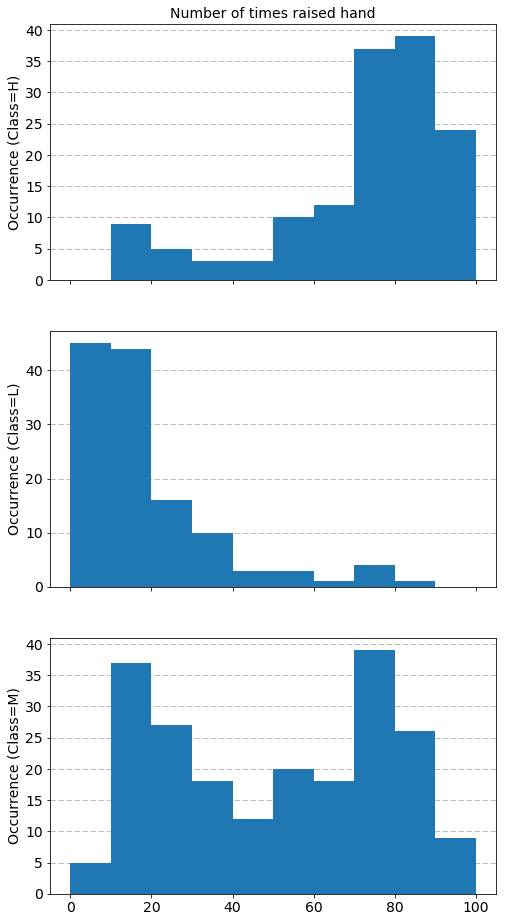

In [5]:
# Extract relevant info
raisedhands = students["raisedhands"]
performance = students["Class"]
grades = ["H", "L", "M"]

# Initialise the subplots
# for the various classes
_, axes = plt.subplots(3,
                       sharex=True,
                       figsize=(8, 16))
    
# Set the overall figure title
axes[0].set_title("Number of times raised hand",
                  fontsize=14)
    
# Get bins to be shared across all histograms
_, shared_bins = np.histogram(raisedhands.values)
    
# Loop over the subplots
for i, ax in enumerate(axes):
        
    # Generate histogram for one class
    filtered = raisedhands[performance==grades[i]]
    ax.hist(filtered, bins=shared_bins)
        
    # Adjust labels, ticks,... 
    ax.set_ylabel("Occurrence (Class={})".format(grades[i]),
                  fontsize=14)
    ax.tick_params(labelsize=14)
        
    # Draw horizontal gridlines
    ax.set_axisbelow(True)
    ax.yaxis.grid(linestyle='dashed')
        
# Show overall figure
plt.show()

Unfortunately, data exploration is rather time consuming. To speed things up, you can use the following interactive widget.

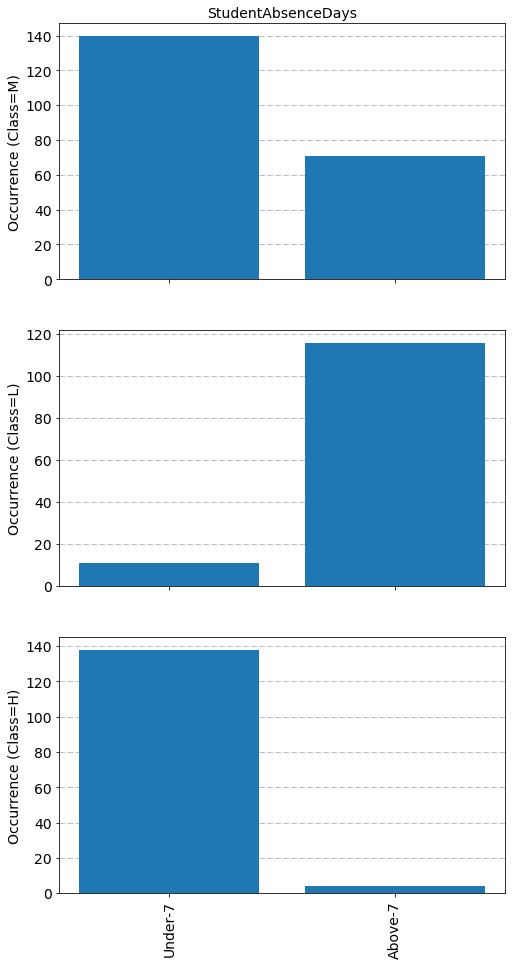

In [6]:
# Interactive data exploration
compare_classes_interactively(students, "Class")

Class imbalance, the situation where there are many less examples belonging to some classes than the others, can severely hinder the performance of a classifier. As a matter of fact, the imbalance often causes classifiers to label instances from the minority classes as examples from the majority ones. This bias towards the majority classes is a source of frequent problems. There are multiple ways class imbalance can result in poor performance:

* The algorithm is programmed to maximise accuracy, that is, the overall number of successes in classifying examples independently of their class. If the dataset is imbalanced, an algorithm that strongly favours the majority classes can obtain high accuracy, as it will return correct predictions for the common majority examples, and incorrect predictions for the rare minority ones. For example, in a problem with two classes ("A" and "B") making up 99% and 1% of the dataset respectively, a classifier that always predicts "A" returns the correct answer 99% of the time. This demonstrates that, if the classes are imbalanced, accuracy is a bad measure of performance, which should **not** be used as the objective function for training a classifier. 

* The algorithm carries an in-built assumption that the classes are balanced.

* The algorithm does not take into account that mistakes arising from different classes have uneven costs. Let us consider, for example, the use of artificial intelligence in detecting credit-card frauds. This machine-learning problem exhibits very imbalanced classes, with "normal transactions" being the majority class, and "fraudulent transactions" being the minority class. To mention some figures, in the dataset of credit-card transactions provided by Kaggle, there are only 492 frauds, as compared to 284,315 ordinary events. Owing to class imbalance, many algorithms will tend to label fraudulent transactions as genuine, producing heavy economic loss to the credit-card company. In such cases, the data scientist must select a classifier that can handle imbalanced classes, and ensure that the unequal costs of misclassifying positive and negative examples are taken into account.

**Exercise 4**: Calculate the size of each class as a percentage of the total. Are the classes very imbalanced?

In [7]:
# There is some class imbalance, 
# but it is not severe
class_size = students["Class"].value_counts()
print("Size of each class as a percentage of the total:")
print(100.*class_size/sum(class_size))

Size of each class as a percentage of the total:
M    43.958333
H    29.583333
L    26.458333
Name: Class, dtype: float64


## Data preprocessing

### Identify target and feature variables

**Exercise 5:** Create two dataframes, containing respectively the features and target variables. 

In [8]:
# Identify the target variable
target_names = ["Class"]
targets = students[target_names]

In [9]:
# Identify the feature variables
feature_names = [x for x in students.columns if x not in target_names]
features = students[feature_names]

### Transform categoric features

Categorical features are represented in two ways. The ordinary encoding makes use of a single column, and specifies the value of the feature as a string, or in some cases as an integer. For example, the ordinary representation of the categorical quantity `ParentschoolSatisfaction` in our dataset of school pupils is: 

|ParentschoolSatisfaction|
|:-:|
|Good|
|Bad|
|Good|
|...|

The alternative, termed one-hot encoding, employs as many columns as distinct values of the feature. Then, it specifies the value of the categorical quantity by placing 1 in the relevant column, and 0 in all other columns. For instance, the one-hot representation of the feature `ParentschoolSatisfaction` is: 

|ParentschoolSatisfaction_Bad|ParentschoolSatisfaction_Good|
|:-:|:-:|
|0|1|
|1|0|
|0|1|
|...|...|

In principle, tree algorithms can handle categorical features independently of the encoding. However, the scikit-learn implementation of decision tree classifiers, used later on in this notebook, essentially requires that categorical quantities are one-hot encoded. This subtlety motivates...

**Exercise 6**: Using the function `pandas.get_dummies` as [documented here](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html), transform all categorical features to one-hot representation.



In [10]:
# Transform to one-hot encoding
features = pd.get_dummies(features)

In [11]:
# Visualise the result
features.sample(5)

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_F,gender_M,NationalITy_Egypt,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,NationalITy_Morocco,NationalITy_Palestine,NationalITy_SaudiArabia,NationalITy_Syria,NationalITy_Tunis,NationalITy_USA,NationalITy_lebanon,NationalITy_venzuela,PlaceofBirth_Egypt,PlaceofBirth_Iran,PlaceofBirth_Iraq,PlaceofBirth_Jordan,PlaceofBirth_KuwaIT,PlaceofBirth_Lybia,PlaceofBirth_Morocco,PlaceofBirth_Palestine,PlaceofBirth_SaudiArabia,PlaceofBirth_Syria,PlaceofBirth_Tunis,PlaceofBirth_USA,PlaceofBirth_lebanon,PlaceofBirth_venzuela,StageID_HighSchool,StageID_MiddleSchool,StageID_lowerlevel,GradeID_G-02,GradeID_G-04,GradeID_G-05,GradeID_G-06,GradeID_G-07,GradeID_G-08,GradeID_G-09,GradeID_G-10,GradeID_G-11,GradeID_G-12,SectionID_A,SectionID_B,SectionID_C,Topic_Arabic,Topic_Biology,Topic_Chemistry,Topic_English,Topic_French,Topic_Geology,Topic_History,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_F,Semester_S,Relation_Father,Relation_Mum,ParentAnsweringSurvey_No,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Bad,ParentschoolSatisfaction_Good,StudentAbsenceDays_Above-7,StudentAbsenceDays_Under-7
209,70,81,39,84,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1
434,85,87,72,10,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0
385,79,93,49,23,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1
116,77,80,12,19,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0
27,25,15,12,33,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0


### Training-validation-test split

As mentioned in the lectures, the standard workflow of machine learning is divided in three parts, called training, validation and testing. Let us recap some key notions.

For decision trees classifiers, the **training** phase determines (i) how to resolve the class of each leaf node, (ii) how to associate features to the root and internal nodes, and (iii) how to set threshold values for the binary splitting of examples. 

The **validation** phase specifies the optimal structure of the tree. More precisely, it identifies the optimal values of meta-parameters such as the maximum depth of the tree (`maxdepth`), the minimum number of samples considered at any one internal node (`min_samples_split`), the minimum number of samples arriving at any one leaf node (`min_samples_leaf`). Here, the names in small-caps are the relevant arguments in the scikit-learn decision tree classifier (`sklearn.tree.DecisionTreeClassifier`).

Finally, the **testing** phase evaluates the reliability of our classifier. Among the performance metrics commonly used to this end, we will discuss precision, recall, F1-score, and the confusion matrix. 

Training, validation and testing must be carried out on separate datasets so as to examine whether the algorithm's predictions generalise to entirely new examples. The tendency of models to achieve good performance on the training set at the expense of generalisation to unfamiliar examples is called **overfitting**, and is a common issue in machine learning. The three-stage workflow just described is arguably the the simplest technique for diagnosing the problem. 

**Exercise 7:** By applying the scikit-learn function `train_test_split` twice, split the dataset in a training part, a validation part, and a testing part. Define the training part to contain 60% of all data, the validation part to contain 25%, and the testing part to contain 15%. Make sure you name variables as follows: 

|Name|Explanation|
|:-:|:-:|
|`X_train`|Features in the training dataset.|
|`X_validate`|Features in the validation dataset.|
|`X_test`|Features in the test dataset.|
|`y_train`|Target variable in the training dataset.|
|`y_validate`|Target variable in the validation dataset.|
|`y_test`|Target variable in the test dataset.|

The function `train_test_split` is [documented here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).  



In [12]:
# Define the training dataset
X_train, X_other, y_train, y_other = train_test_split(features, targets, test_size=2./5.)

# Define the validation and test datasets
X_validate, X_test, y_validate, y_test = train_test_split(X_other, y_other, test_size=3./8.)

In [13]:
# Check the split worked as intended
percentage_train = len(y_train)*100./len(targets)
percentage_validate = len(y_validate)*100./len(targets)
percentage_test = len(y_test)*100./len(targets)
print("Size of training set as a percentage of the total: {}".format(percentage_train))
print("Size of validation set as a percentage of the total: {}".format(percentage_validate))
print("Size of test set as a percentage of the total: {}".format(percentage_test))

Size of training set as a percentage of the total: 60.0
Size of validation set as a percentage of the total: 25.0
Size of test set as a percentage of the total: 15.0


## Machine learning

In this section, we will employ a decision tree algorithm so as to classify students according to their marks. 

### Simplified workflow

To keep things simple, let us momentarily neglect the second step in the training-validation-testing workflow. As mentioned above, the validation phase identifies the optimal tree structure by tuning metaparameters such as `min_samples_leaf`, the minimum number of samples arriving at any one leaf node. Here, we will assume that this quantity is fixed (`min_samples_leaf = 7`), and thus implement the training and testing phases only. The complete recommended workflow, inclusive of model validation, is presented later on in this notebook.

**Exercise 8:** Initalise the tree classifier using `DecisionTreeClassifier`. You may want to have a look at the [corresponding documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) from scikit-learn. Set the number of samples per leaf (`min_samples_leaf`) to be 7, and the function measuring the quality of splits (`criterion`) to be the cross entropy. Lastly, to mitigate the adverse effects of class imbalance, prescribe that `class_weight="balanced"`. 

**Note**: Because tree algorithms are quite sensitive to class imbalance, they should be used in conjunction with techniques that alleviate the problem. A review of strategies for dealing with class imbalance is offered in [this blogpost](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). Here, we will employ the built-in method of scikit-learn's `DecisionTreeClassifier`, which one activates by setting `class_weight="balanced"`. This assigns greater "weights" to examples from the minority classes, offering a relatively effective way to even out the class imbalance. 

In [14]:
# Initialise decision tree
classifier = DecisionTreeClassifier(criterion="entropy",
                                    min_samples_leaf=7,
                                    class_weight="balanced")

**Exercise 9**: Fit, that is to say, **train** the decision tree algorithm. 

In [15]:
# Model training
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

**Exercise 10**: Generate predictions, and **test** the classifier by determining its precision, recall and F1-score. These metrics are easily computed using the function `precision_recall_fscore_support` from scikit-learn. 

**Note:** In a problem with two classes, labeled positive and negative, one has the following definitions: 

* **True Positives (`TP`):** examples correctly predicted to be in the positive class. 
* **False Positives (`FP`):** examples incorrectly predicted to be in the positive class.
* **True Negatives (`TN`):** examples correctly predicted to be in the negative class.
* **False Negatives (`FN`):** examples incorrectly predicted to be in the negative class.
* **Precision:** `TP/(TP + FP)`. It quantifies how often predictions of positive are correct.
* **Recall:** `TP/(TP + FN)`. It quantifies how often actual positive examples are predicted correctly. 
* **F1-Score:** `2*(Precision * Recall)/(Precision + Recall)`. It is the harmonic mean of precision and recall.

In a problem with multiple classes, the definitions are generalised through a one-vs-all approach. One class at a time is interpreted as "positive", while the combination of all others is interpreted as "negative". This yields estimates of precision, recall and F1-score that are individual to each class.

It is worthwhile to remark that some performance metrics, including precision and recall, become flawed when class imbalance is severe. On the other hand, the F1-score is moderately insensitive to the problem. This justifies our preference for this metric in subsequent exercises. 

In [16]:
# Model testing 
y_predicted_test = classifier.predict(X_test)

# Get precision, recall,
# f1_score and support
metrics = precision_recall_fscore_support(y_test, y_predicted_test)

# Display metrics in a nice format
# by creating a suitable dataframe
metric_names = ["Precision", "Recall", "F1_Score", "Support"]
metrics = dict(zip(metric_names, metrics))
metrics = pd.DataFrame(metrics)
metrics["Class"] = ["H", "L", "M"]
metrics

,F1_Score,Precision,Recall,Support,Class
0,0.608696,0.736842,0.518519,27,H
1,0.864865,0.800000,0.941176,17,L
2,0.655738,0.606061,0.714286,28,M


### Complete workflow

This section presents the standard workflow of machine learning, whose three parts are model training, validation and testing. 

The validation phase identifies the optimal value of meta-parameters like `min_samples_leaf`, which specify the structure of our decision tree. This intermediate stage is necessary so as to prevent a less common type of overfitting. In a situation where no validation set is employed, meta-parameters are optimised against the test set, and can be adjusted so as to obtain seemingly perfect classification. The effect, however, is due to a subtle kind of overfitting that originates from tuning the meta-parameters. When applied on an entirely new dataset, the classifier will exhibit low performance, as its predictions will not generalise to the "unfamiliar" situation. In summary, it is recommended that (i) the groundwork of learning is carried out on the training set, (ii) meta-parameters are optimised against the validation set, and (iii) classifier performance is judged on the basis of the test set. 

#### Model training and validation

We will now select the value of `min_samples_leaf` that maximises the F1-score against the validation dataset. Subsequently, we will evaluate the performance of the resulting classifier on the test dataset. 

**Excercise 11: ** Reuse code from Exercise 10 to complete the function `train_and_validate`. 

In [17]:
def train_and_validate(min_samples_leaf_list,
                       X_train,
                       X_validate,
                       y_train,
                       y_validate):
    """Train and validate decision trees for different values of minimum leaf size.
    
    Parameters
    ----------
    min_samples_leaf_list : list
        Values of minimum leaf size.
    X_train : array-like
        Features in training dataset. 
    X_validate : array-like
        Features in validation dataset.    
    y_train : array-like
        Targets in training dataset.
    y_validate : array-like
        Targets in validation dataset.
    
    Returns
    -------
    classifiers : list of trained models
        Decision trees with different minimum leaf size. 
    f1_scores : list
        F1-scores calculated on the validation dataset.
    """
    # Initalise storage
    classifiers = [] # Populate with trained decision trees
    f1_scores = [] # Populate with F1-scores
    
    # Loop over values of 
    # minimum leaf size
    for min_samples_leaf in min_samples_leaf_list:
        
        # Initialise decision tree
        classifier = DecisionTreeClassifier(criterion="entropy",
                                            min_samples_leaf=min_samples_leaf,
                                            class_weight="balanced")
        
        # Model training
        classifier.fit(X_train, y_train)
        classifiers.append(classifier) # Save trained model
        
        # Model validation
        y_predicted_validate = classifier.predict(X_validate)
        f1 = f1_score(y_validate, y_predicted_validate, average="micro")
        f1_scores.append(f1) # Save f1_score
    
    return classifiers, f1_scores

In [18]:
# Training and validation for different
# values of minimum leaf size
MIN_SAMPLES_LEAF_LIST = [i for i in range(5, 30)]
classifiers, f1_scores = train_and_validate(MIN_SAMPLES_LEAF_LIST,
                                            X_train,
                                            X_validate,
                                            y_train,
                                            y_validate)

**Exercise 11:** Plot the F1-score for different values of `min_samples_leaf` in the range from 5 to 30. By using this graph, find the number of samples per leaf node that yields the best performance. 

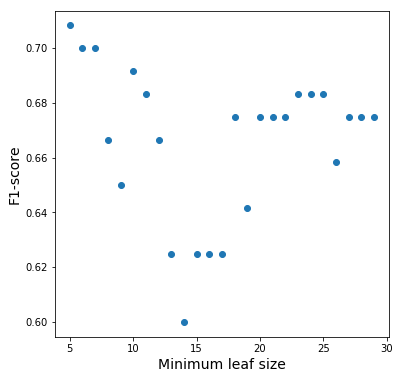

In [19]:
# Plot F1-scores of trained models
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(MIN_SAMPLES_LEAF_LIST, f1_scores, 'o')
ax.set_xlabel("Minimum leaf size", size=14)
ax.set_ylabel("F1-score", size=14)
plt.show()

**Exercise 12:** Among the classifiers returned by the function `train_and_validate`, choose the model that attains the highest F1-score. You may want to automate the selection, eliminating the need to inspect the plot from Exercise 11. 

In [20]:
# Select model with highest F1-score
top_classifier = classifiers[argmax(f1_scores)]

#### Testing the top classifier

**Exercise 12:** In analogy with Exercise 10, test the optimal classifier by determining its precision, recall and F1-score. 

In [21]:
# Model testing  
y_predicted_test = top_classifier.predict(X_test)

# Get precision, recall,
# f1_score and support
metrics = precision_recall_fscore_support(y_test, y_predicted_test)

# Display metrics in a nice format
# by creating a suitable dataframe
metric_names = ["Precision", "Recall", "F1_Score", "Support"]
metrics = dict(zip(metric_names, metrics))
metrics = pd.DataFrame(metrics)
metrics["Class"] = ["H", "L", "M"]
metrics

,F1_Score,Precision,Recall,Support,Class
0,0.600000,0.652174,0.555556,27,H
1,0.800000,0.695652,0.941176,17,L
2,0.592593,0.615385,0.571429,28,M


Another powerful technique for evaluating classifier performance is the confusion matrix. To understand how a confusion matrix works, it is sufficient to appreciate the meaning of its entries. More specifically, the entry in row `i` and column `j` of the confusion matrix is the number of examples from class `i` that are predicted to belong to class `j`. As a result, diagonal entries keep track of correct predictions, while off-diagonal entries keep track of incorrect predictions. The confusion matrix, however, conveys information beyond the simple divide between correct and incorrect preditions. An important advantage of the confusion matrix is the fact that it describes precisely how the algorithm mis-classifies examples.

**Exercise 13:** Calculate the confusion matrix using the function `confusion_matrix` from scikit-learn. Then, inspect the result by means of the function `plot_confusion_matrix` from our `visualise` module.

Confusion matrix, without normalisation.


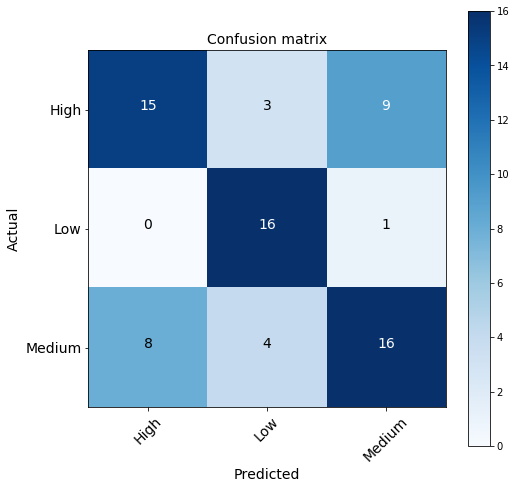

In [22]:
# Calculate and plot confusion matrix
confusion = confusion_matrix(y_test, y_predicted_test)
plot_confusion_matrix(confusion,
                      labels=["High", "Low", "Medium"],
                      normalise=None)

## Feature importance

Decision trees, as well as random forests, can quantify how much a given feature contributed to separating the examples into classes. This knowledge is valuable, as it can inform business decisions directly. For example, an airline will be interested not only in predicting whether someone will purchase a ticket, but also in identifying which features govern his/her choice. 

In scikit-learn, to extract the **feature importance** from a decision-tree object, one makes use of the attribute `.feature_importances_`. This returns the sum of decreases in Gini impurity as measured at the internal nodes corresponding to a given feature; additional information is [provided here](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp).

**Exercise 14:** Find the 10 most important features in our classification problem about school students. 

In [23]:
# Extract feature importances
importances = top_classifier.feature_importances_

# Create dataframe with feature names
# and percent importances as columns
feature_scores = pd.DataFrame()
feature_scores["Feature"] = features.columns
feature_scores["PercentImportance"] = 100.*importances

# Sort dataframe in order of 
# descending feature importance
feature_scores = feature_scores.sort_values("PercentImportance",
                                            ascending=False)
feature_scores = feature_scores.reset_index(drop=True)

# Display the 10 most
# important features
feature_scores.head(10)

,Feature,PercentImportance
0,StudentAbsenceDays_Under-7,36.911800
1,VisITedResources,26.259446
2,AnnouncementsView,9.789179
3,Discussion,8.505875
4,raisedhands,5.138785
5,gender_M,4.728549
6,Relation_Mum,4.234929
7,GradeID_G-02,0.891319
8,Topic_IT,0.831637
9,PlaceofBirth_KuwaIT,0.761652
